In [1]:
import random
import numpy as np
import pandas as pd

from copy import copy
from datetime import datetime
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
class Problem:
    def __init__(self,path):
            
        with open(path, 'r') as f:
            file = f.read()
            file = file.split('\n')
    
        for i, row in enumerate(file):
            if 'COMMENT' in row:
    
                pat = 'No of trucks:'
                ind = row.find(pat)+len(pat)
                end = ind + row[ind:].index(',')
                self.n_trucks = int(row[ind+1:end])
    
                pat = 'Optimal value:'
                ind = row.find(pat)+len(pat)
                end = ind + row[ind:].index(')')
                self.optimal = int(row[ind+1:end])
    
            if 'CAPACITY' in row:
                pat = 'CAPACITY :'
                ind = row.find(pat)+len(pat)
                self.capacity = int(row[ind+1:])
    
            if 'NODE_COORD_SECTION' in row:
                locations = []
                for j, location in enumerate(file[i+1:]):
                    if 'DEMAND_SECTION ' in location:
                        break
                    _, x, y = location[1:].split(' ')
                    locations.append((float(x), float(y)))
                self.locations = locations
                self.n_locations = len(locations)
    
            if 'DEMAND_SECTION' in row:
                demands = []
                for k, demand in enumerate(file[i+1:]):
                    if 'DEPOT_SECTION' in demand:
                        break
                    i, demand = demand[:-1].split(' ')
                    if float(demand) == 0:
                        self.depot_i = int(i) - 1
                    demands.append((float(demand)))
    
                assert self.n_locations == len(demands)
                self.demands = demands
                break
    
        locations = self.locations
        n = self.n_locations
        dists = np.ones((n, n), dtype=np.float32)
        dists *= -1
        for comb in combinations(np.arange(n, dtype=np.int32), 2):
            i, j = comb
            if i != j and dists[i,j] == -1:
                d = np.linalg.norm([x - y for x, y in
                                    zip(locations[i] , locations[j])])
                dists[i, j] = d
                dists[j, i] = d
        self.dists = dists

    

In [3]:
aname = 'tests/A-n32-k5.vrp'
problem = Problem(aname)
name1 = 'tests/A-n33-k5.vrp'
problem1 = Problem(name1)
name2 = 'tests/A-n33-k6.vrp'
problem2 = Problem(name2)
name3 = 'tests/A-n34-k5.vrp'
problem3 = Problem(name3)
name4 = 'tests/A-n36-k5.vrp'
problem4 = Problem(name4)
name5 = 'tests/A-n37-k5.vrp'
problem5 = Problem(name5)
name6 = 'tests/A-n37-k6.vrp'
problem6 = Problem(name6)
name7 = 'tests/A-n38-k5.vrp'
problem7 = Problem(name7)



In [4]:
problem
print(len(problem1.locations))
print(problem1.n_locations)
print(len(problem1.dists))


33
33
33


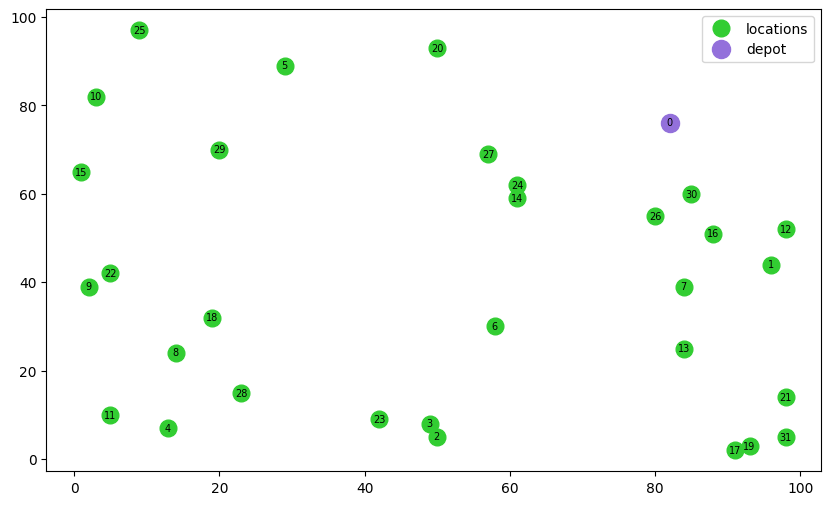

In [5]:
 plt.figure(figsize=(10, 6))
locations = problem.locations


for i, loc in enumerate(locations):
    if len(str(i)) == 1:
        xoff, yoff = 0.5, 0.6
    else:
        xoff, yoff = 0.85, 0.7
    plt.annotate("{}".format(i),
                 (loc[0]-xoff, loc[1]-yoff),
                size=7,
                color='black')
 plt.plot([loc[0] for loc in locations],
         [loc[1] for loc in locations], 'o',
         label='locations',
         color='limegreen',
         markersize=12)
depot = locations[problem.depot_i]
plt.plot(depot[0], depot[1], 'o', label='depot', markersize=13, color='mediumpurple')
plt.legend()

In [6]:
def compute_solution(problem, solution) -> np.float32:
    
    n = problem.n_locations
    len_s = len(solution)
    x = np.zeros((n, n), dtype=np.int32)
    
    for i in range(len_s-1):
        x[solution[i], solution[i+1]] = 1
    cost = problem.dists[x == 1].sum()
    
    return cost


In [7]:
def check_solution(problem,
                   solution,
                   x=None) -> bool:
    
    # sanity check 1
    # len(solution) == n_locations + n_trucks
    sol_len  = len(solution)
    plan_len = problem.n_trucks + problem.n_locations
    if sol_len != plan_len:
        return False

    # sanity check 2
    # The end and the start of the solution should be depot
    if solution[0] != 0 or solution[sol_len-1] !=0:
        return False

    # sanity check 3
    # there shouldn`t be several depots in a row for example [0, 0,.. ]
    depots = list(filter(lambda i: solution[i]==0, range(sol_len)))
    for i in range(len(depots)-1):
        if depots[i+1] - depots[i] <= 1:
            return False


    # sanity check 4
    # all locations should be in the solution
    if len(np.unique(solution)) != problem.n_locations:
        return False

    
    if  not isinstance(x, np.ndarray):
        n = problem.n_locations
        x = np.zeros((n, n), dtype=np.int32)
        for i, loc in enumerate(solution[:-1]):
            x[solution[i], solution[i+1]] = 1

    # cruteria check 1
    # Sum Xi0 = M For all i in V
    # Sum X0j = M For all j in V and
    # where M is the number of trucks
    if not check_M_criteria(problem,
                            solution,
                            x=x):
        return False

    # criteria check 2
    # Sum Xij = 1 For all j in V\{0} and
    # Sum Xij = 1 For all i in V\{0}
    if not check_One_criteria(problem,
                              solution,
                              x=x):
        return False

    # criteria check 3
    # route  demand  <= truck capacity
    if not check_capacity_criteria(problem,
                                   solution):
        return False

    return True


In [8]:
def check_depots_sanity(solution):
    sol_len = len(solution)
    depots = list(filter(lambda i: solution[i]==0, range(sol_len)))
    for i in range(len(depots)-1):
        if abs(depots[i+1] - depots[i]) <= 1:
            return False
    return True

In [9]:
def check_One_criteria(problem,
                       solution,
                       x=None) -> bool:

    if  not isinstance(x, np.ndarray):
        n = problem.n_locations
        x = np.zeros((n, n), dtype=np.int32)
        for i, loc in enumerate(solution[:-1]):
            x[solution[i], solution[i+1]] = 1
            
    if not ((x.sum(axis=1)[1: ].sum() == problem.n_locations - 1) and
            (x.sum(axis=0)[1: ].sum() == problem.n_locations - 1)):
            return False

    return True



In [10]:
def check_M_criteria(problem,
                     solution,
                     x=None) -> bool:
    if  not isinstance(x, np.ndarray):
        n = problem.n_locations
        x = np.zeros((n, n), dtype=np.int32)
        for i, loc in enumerate(solution[:-1]):
            x[solution[i], solution[i+1]] = 1
    
    if  not ((x[0, :].sum() == problem.n_trucks) and
              x[:, 0].sum() == problem.n_trucks):
        return False

    return True

In [11]:
def check_capacity_criteria(problem,
                            solution) -> bool:
    capacity = problem.capacity
    routes_demand = get_routes_demand(problem, solution)
    for route_demand in routes_demand:
        if route_demand > capacity:
            return False
    return True


In [12]:
def get_routes(solution):
    sol_len = len(solution)
    depots  = list(filter(lambda i: solution[i]==0, range(sol_len)))
    routes  = []
    for i, d in  enumerate(depots[:-1]):
        route = solution[depots[i]+1:depots[i+1]]
        routes.append(route)
    return routes

In [13]:
def get_routes_demand(problem, solution : np.array):
    new_solution = copy(solution)
    sol_len = len(new_solution)
    demands = problem.demands
    depots = list(filter(lambda i: new_solution[i]==0, range(sol_len)))
    routes = []
    for i, d in  enumerate(depots[:-1]):
        route = new_solution[depots[i]+1:depots[i+1]]
        route_demand = np.sum([demands[place] for place in route])
        routes.append(route_demand)
    return routes

In [14]:
import random
import numpy as np
from copy import copy
from random import randint
from itertools import combinations


class NeighborOperator:

    def __init__(self):
        self.operators = {
                          1: self.random_swap,
                          2: self.random_swap_sub,
                          3: self.random_insert,
                          4: self.random_insert_sub, 
                          5: self.random_reversing,
                          6: self.random_swap_sub_reverse,
                          7: self.random_insert_sub_reverse,
                          8: self.random_cyclic_shift,
                          9: self.random_swap_adjacent_elements
                          }
        


    def random_operator(self, solution, num_iters=10):
        operators = list(self.operators)
        rand_choice = np.random.choice(operators)
        random_oper = self.operators[rand_choice]
        return random_oper( solution, num_iters=num_iters)

    @staticmethod
    def random_swap(solution, num_iters=10):
        
        new_solution = copy(solution)
        sol_len  = len(new_solution)
        while num_iters > 0:
            i, j = random.sample(range(1, sol_len-1), 2)
            if i != j and new_solution[i] != 0 and new_solution[j] != 0:
                new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
                
            if check_depots_sanity(new_solution):
                    return new_solution
            num_iters -= 1


        return solution

    @staticmethod
    def random_swap_sub(solution, num_iters=10):

        while(num_iters>0):
            new_solution = copy(solution)
            sol_len  = len(new_solution) 
            
            i,j,k,l = random.sample(range(1,sol_len-1),4)
            i,j,k,l = sorted([i,j,k,l])
          
            new_solution[:i] = solution[:i]
            new_solution[i:i+(l-k+1)] = solution[k:l+1]
            new_solution[i+(l-k+1):i+(l-k+1)+(k-(j+1))] = solution[j+1:k]
            new_solution[i+(l-k+1)+(k-(j+1)):i+(l-k)+(k-(j+1))+(j-i+1)+1] = solution[i:j+1]

            if check_depots_sanity(new_solution):
                return new_solution
            num_iters -= 1
            
        return solution

    @staticmethod
    def random_insert(solution, num_iters=10):

        new_solution = copy(solution)
        sol_len  = len(new_solution)
        while num_iters > 0:
            i, j = random.sample(range(1, sol_len-1), 2)
            if i != j and new_solution[i] != 0 and new_solution[j] != 0:
                i, j = copy(min(i, j)), copy(max(i, j))
                if new_solution[j+1] != 0 or new_solution[j-1]!=0:
                    new_solution[:i] = solution[:i]
                    new_solution[i]  = solution[j]
                    new_solution[i+1:j+1] = solution[i:j]
                    new_solution[j+1:]    = solution[j+1:]
                    break
            num_iters -= 1      
        
        return new_solution

    @staticmethod
    def random_insert_sub(solution, num_iters=10):
        new_solution = copy(solution)
        sol_len  = len(new_solution)
        while num_iters > 0:
    
            i, j = random.sample(range(1, sol_len-1), 2)
            i, j = copy(min(i, j)), copy(max(i, j))
            k = random.choice(range(1, sol_len-1))
    
            if k < i:          
                new_solution[:k] = solution[:k]
                new_solution[k:k+(j-i+1)]  = solution[i:j+1]
                new_solution[k+(j-i+1):k+(j-i+1)+(i-k)] = solution[k:i]
                new_solution[k+(j-i+1)+(i-k):]  = solution[j+1:]
                if check_depots_sanity(new_solution):
                    break
            elif k > j:
                new_solution[:i] = solution[:i]
                new_solution[i:i+k-(j+1)] = solution[j+1:k]
                new_solution[i+k-(j+1):i+k-(j+1)+(j-i+1)] = solution[i:j+1]
                new_solution[i+k-(j+1)+(j-i+1):] = solution[k:]
                
                if check_depots_sanity(new_solution):
                    return new_solution
    
            num_iters -= 1
    
        return solution

    @staticmethod
    def random_reversing(solution, num_iters=10):

        new_solution = copy(solution)
        sol_len  = len(new_solution)
        while num_iters > 0:
            i, j = sorted(random.sample(range(1, sol_len-1), 2))
            new_solution[i:j+1] = new_solution[j:i-1:-1]

            if check_depots_sanity(new_solution):
                    return new_solution
                
            num_iters -= 1

        return solution

    @staticmethod
    def random_swap_sub_reverse(solution, num_iters=10):

        while(num_iters>0):
            new_solution = copy(solution)
            sol_len  = len(new_solution) 
            
            i,j,k,l = random.sample(range(1,sol_len-1),4)
            i,j,k,l = sorted([i,j,k,l])
          
            new_solution[:i] = solution[:i]
    
            if (random.random() > 0.5):
                new_solution[i:i+(l-k+1)] = solution[k:l+1]
            else:
                new_solution[i:i+(l-k+1)] = solution[l:k-1:-1]
            
            new_solution[i+(l-k+1):i+(l-k+1)+(k-(j+1))] = solution[j+1:k]
            
            if (random.random() > 0.5):
                new_solution[i+(l-k+1)+(k-(j+1)):i+(l-k)+(k-(j+1))+(j-i+1)+1] = solution[i:j+1]
            else:
                new_solution[i+(l-k+1)+(k-(j+1)):i+(l-k)+(k-(j+1))+(j-i+1)+1] = solution[j:i-1:-1]

                        
            if check_depots_sanity(new_solution):
                    return new_solution
            num_iters -= 1
            
        return solution
    

    @staticmethod
    def random_insert_sub_reverse(solution, num_iters=10):
    
        new_solution = copy(solution)
        sol_len  = len(new_solution)
        while num_iters > 0:
            if random.random() > 0.5:
                k, i, j  = sorted(random.sample(range(1, sol_len-1), 3))
            else: 
                i,j,k = sorted(random.sample(range(1, sol_len-1), 3))
            
            if k < i:  
                new_solution[:k] = solution[:k]
                new_solution[k:k+(j-i+1)]  = solution[j:i-1:-1]
                new_solution[k+(j-i+1):k+(j-i+1)+(i-k)] = solution[k:i]
                new_solution[k+(j-i+1)+(i-k):]  = solution[j+1:]
            else:
                new_solution[:i] = solution[:i]
                new_solution[i:i+(k-(j+1))] = solution[j+1:k]
                new_solution[i+(k-(j+1)): i+(k-(j+1))+(j-i+1)] = solution[j:i-1:-1]
                new_solution[i+(k-(j+1))+(j-i+1):] = solution[k:]
    
            if check_depots_sanity(new_solution):
                return new_solution
            num_iters -= 1
        
        return solution

    @staticmethod
    def random_cyclic_shift(solution, num_iters=10):

        new_solution = copy(solution)
        
        first_element = new_solution[0]
        last_element = new_solution[-1]
        
        middle_elements = new_solution[1:-1]
          
        sol_len = len(middle_elements)
        while num_iters > 0:
            k = random.randint(1, sol_len-1)
            
            k_left = middle_elements[-k:]
            k_right = middle_elements[:-k]
            new_middle_elements = np.concatenate((k_left, k_right))            
            new_solution[1:-1] = new_middle_elements
            
            if check_depots_sanity(new_solution):
                return new_solution
                
            num_iters -= 1
        

        return solution
        
    @staticmethod
    def random_swap_adjacent_elements(solution, num_iters=10):
        
        new_solution = copy(solution)
        
        first_element = new_solution[0]
        last_element = new_solution[-1]
        
        middle_elements = new_solution[1:-1]
      
        for i in range(0, len(middle_elements)-1, 2):
           middle_elements[i], middle_elements[i+1] = middle_elements[i+1], middle_elements[i]
        
        new_solution[1:-1] = middle_elements
        
        if check_depots_sanity(new_solution):
            return new_solution
        
        return solution


In [15]:
def generate_neighborhood(problem,solution,num_iters):

    feasible_saving = copy(solution)
    operator = NeighborOperator()
    neighborhood = []
    for i in range(num_iters):
        tmp_sol = operator.random_operator(solution)
        if check_solution(problem, tmp_sol):
            neighborhood.append(tmp_sol)

    return neighborhood

In [16]:
def calc_fitness(problem,solution ,alpha=0.5):
    c = compute_solution(problem, solution)
    demands = get_routes_demand(problem, solution)
    q = 0
    for demand in demands:
        if demand > problem.capacity:
            q += (demand - problem.capacity)
    
    return  (c + alpha * q)

In [17]:
class Bee:

    def __init__(self,problem,alpha):
        self.problem = problem
        self.code = self.generate_solution()
        self.fitness = calc_fitness(problem,self.code,alpha)
        self.counter = 0
        

    def generate_solution(self,num_iters=1000):
        n = self.problem.n_locations
        m = self.problem.n_trucks
        
        for _ in range(num_iters):
            solution = [0]
            locations = random.sample(range(1,n),n-1)
            trucs = random.sample(range(1,n+m-1),m-1)
            for i in range(1,n+m-1):
                if i in trucs:
                    solution.append(0)
                else:
                    solution.append(locations[0])
                    locations = locations[1:]
            solution.append(0)
    
            if check_depots_sanity(solution):
                if check_capacity_criteria(self.problem, solution):
                    break
                    
        return np.array(solution)


def get_fitness(bee):
    return bee.fitness 


def compare(bee):
    return bee.fitness - compute_solution(bee.problem,bee.code)



In [18]:
def ABC(
        problem: Problem,
        alpha=0.2,
        delta=0.01,
        n_epoch=1000,
        initial_food_sources=25,
        onlookers=25,
        counter_limit=5
        ):


        fitness_history = []
        alpha_history = []
        solutions = [Bee(problem,alpha) for _ in range(initial_food_sources) ]
        operator  = NeighborOperator()

        for _ in range(n_epoch):
            
            # for each food source apply neighbor operator
            for i, solution in enumerate(solutions):
    
                neighbor = operator.random_operator(solution.code)
                nfitness = calc_fitness(solution.problem,neighbor,alpha)
                if nfitness < solutions[i].fitness:
                    solutions[i].code = neighbor
                    solutions[i].fitness = nfitness
                    solutions[i].counter  = 0
                else:
                    solutions[i].counter  += 1
    
            
    
            # for each onlooker select food source
            # *based on roulette wheel choice
            neighborhood = [[] for _ in range(initial_food_sources)]
            f_sum  = sum(solution.fitness for solution in solutions)
            probs  = [solution.fitness / f_sum  for solution in solutions]
        
            for _ in range(onlookers):
                roulette = np.random.choice(range(len(probs)), p=probs)
                solution = solutions[roulette]
                neighborhood[roulette].append(operator.random_operator(solution.code))
        
            
            for i, neighbors in enumerate(neighborhood):
                if neighbors:
                    neighbors_fitness = [calc_fitness( problem, neighbor ,alpha) for neighbor in neighbors]
                    min_fitness = min(neighbors_fitness)
                    if min_fitness < solutions[i].fitness:
                        solutions[i].code = neighbors[np.argmin(neighbors_fitness)]
                        solutions[i].fitness = min_fitness
                        solutions[i].counter   = 0
                    else:
                        solutions[i].counter  += 1
    

            
            # for each food source check limit
            # if counter = limit then replace generate random solution
            for i in range(initial_food_sources):
                if solutions[i].counter  == counter_limit:
                    solutions[i] = Bee(problem,alpha)

            num_violation = 0
            for solution in solutions:
                if (not check_capacity_criteria(problem,solution.code)) or (not check_M_criteria(problem,solution.code)) or (not check_One_criteria(problem,solution.code)):
                    num_violation+=1
            
            alpha_history.append(alpha)

            if num_violation > (len(solutions)/2):
                alpha *= (1+delta)
            else:
                alpha /= (1+delta)


        for i in range(initial_food_sources):
            solutions[i].fitness=calc_fitness(problem,solutions[i].code,alpha)

        # return the best feasible solution
        solutions.sort(key=compare)
        best_solution = solutions[0]
        for solution in solutions:
            if check_solution(problem,solution.code):
                return solution , fitness_history , alpha_history 
                
        return best_solution , fitness_history , alpha_history 

In [19]:
def ABC_with_elitism(
        problem: Problem,
        alpha=0.2,
        delta=0.01,
        n_epoch=1000,
        initial_food_sources=30,
        onlookers=20,
        counter_limit=50*30,
        elitism_size = 5
        ):


        fitness_history = []
        alpha_history = []
        solutions = [Bee(problem,alpha) for _ in range(initial_food_sources) ]
        operator  = NeighborOperator()

        for _ in range(n_epoch):
        
            # for each food source apply neighbor operator
            for i in range(initial_food_sources):
                neighbor = operator.random_operator(solutions[i].code)
                nfitness = calc_fitness(problem,neighbor,alpha)
                if nfitness < solutions[i].fitness:
                    solutions[i].code = neighbor.copy()
                    solutions[i].fitness = nfitness
                    solutions[i].counter  = 0
                else:
                    solutions[i].counter  += 1

            
            # for each onlooker select food source
            # based on roulette wheel choice
            neighborhood = [[] for _ in range(initial_food_sources)]
            f_sum  = sum(solution.fitness for solution in solutions)
            probs  = [solution.fitness / f_sum  for solution in solutions]
        
            for _ in range(onlookers):
                roulette = np.random.choice(range(len(probs)), p=probs)
                solution = solutions[roulette]
                neighborhood[roulette].append(operator.random_operator(solution.code))

            
            for i, neighbors in enumerate(neighborhood):
                if neighbors:
                    neighbors_fitness = [calc_fitness( problem, neighbor ,alpha) for neighbor in neighbors]
                    min_fitness = min(neighbors_fitness)
                    if min_fitness < solutions[i].fitness:
                        solutions[i].code = neighbors[np.argmin(neighbors_fitness)].copy()
                        solutions[i].fitness = min_fitness
                        solutions[i].counter   = 0
                    else:
                        solutions[i].counter  += 1


            solutions.sort(key = get_fitness)
            
            # for each food source check limit
            # if counter = limit then replace generate random solution
            for i in range(elitism_size,len(solutions)):
                if solutions[i].counter  >= counter_limit:
                    solutions[i] = Bee(problem,alpha)

            num_violation = 0
            for solution in solutions:
                if (not check_capacity_criteria(problem,solution.code)) or (not check_M_criteria(problem,solution.code)) or (not check_One_criteria(problem,solution.code)):
                    num_violation+=1
            
            
            alpha_history.append(alpha)

            if num_violation > len(solutions)/2:
                alpha *= (1+delta)
            else:
                alpha /= (1+delta)


            for i in range(initial_food_sources):
                solutions[i].fitness=calc_fitness(problem,solutions[i].code,alpha)
                

        solutions.sort(key = compare)
        
        for solution in solutions:
            if check_solution(problem,solution.code):
                return solution , fitness_history , alpha_history 
        return solutions[0] , fitness_history , alpha_history 

In [20]:

import time
time_history = [] 
fitness_history = []

elitism_time_history = []
elitism_fitness_history = []

for i in range(100):
        print(i)
        start_time = time.time()
        solution  ,_,_= ABC(
        problem=problem,
        alpha=0.1,
        delta=0.001,
        n_epoch=i,
        initial_food_sources=25,
        onlookers=25,
        counter_limit=50
        )
        time_history.append(time.time() - start_time) 
        fitness_history.append(compute_solution(problem, solution.code))


for i in range(100):
        print(i)
        start_time = time.time()
        solution  ,_,_= ABC_with_elitism(
        problem=problem,
        alpha=0.1,
        delta=0.001,
        n_epoch=i,
        initial_food_sources=25,
        onlookers=25,
        counter_limit=50,
        elitism_size=5
        )
        elitism_time_history.append(time.time() - start_time) 
        elitism_fitness_history.append(compute_solution(problem, solution.code))
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


KeyboardInterrupt: 

In [ ]:
print("solution = ",solution.code)
print("fitness = ",solution.fitness, "cost = ", compute_solution(problem,solution.code) )
print(check_solution(problem, solution.code))
print("-----------------------------------------------------------------------")
print(solutionE.code)
print("fitnessE = ",solutionE.fitness,"costE=", compute_solution(problem,solutionE.code))
print(check_solution(problem, solutionE.code))


print("-----------------------------------------------------------------------")
sol = [0,20,5,25,10,15,22,9,8,18,29,0,27,24,0,14,28,11,4,23,3,2,6,0,26,7,13,17,19,31,21,0,30,16,1,12,0]

print(compute_solution(problem,sol))

In [ ]:

import statistics
def visualize_fitness(history,text):
    plt.figure(figsize=(9,4))
    plt.plot(history, label=text)
    plt.ylabel(text)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


visualize_fitness(fitness_history,"cost (random swap adjacent elements)")
print("Original average: ",statistics.mean(fitness_history))
print("Best solution: ",min(fitness_history))
visualize_fitness(time_history,"time")

print("Elitism average: ", statistics.mean(elitism_fitness_history))
print("Best_solution: ",min(elitism_fitness_history))
visualize_fitness(elitism_fitness_history,"elitism cost (random swap adjacent elements)")
visualize_fitness(elitism_time_history,"elitism time")


In [21]:
from itertools import permutations

def generate_all_permutations(n_locations,n_trucks):
    solution = []
    for i in range(n_locations):
        solution.append(i)
    for _ in range(n_trucks):
        solution.append(0)
    all_permutations = list(permutations(solution))
    
    return all_permutations
    


In [22]:
cname = 'tests/cvrp5.vrp'
problemC = Problem(cname)

In [23]:
import time
def brute_force_cvrp(problem):
    best_solution = None
    best_fitness = 0
    

    
    start_time = time.time()
    all_permutations = generate_all_permutations(problem.n_locations,problem.n_trucks)

    
    for permutation in all_permutations:

        if not check_solution(problem,permutation):
            continue
                
        curr_fitness = calc_fitness(problem,permutation)
        if curr_fitness > best_fitness:
            best_solution = permutation
            best_fitness = curr_fitness

    time1 = time.time() - start_time
    return best_solution, best_fitness, time1



In [ ]:
best_solution , best_fitness ,time1 = brute_force_cvrp(problemC)

print(best_fitness)
print(time1)

In [ ]:

import time
time_history2 = [] 
fitness_history2 = []

elitism_time_history2 = []
elitism_fitness_history2 = []

for i in range(100):
        print(i)
        start_time = time.time()
        solution  ,_,_= ABC(
        problem=problem7,
        alpha=0.1,
        delta=0.001,
        n_epoch=1000,
        initial_food_sources=25,
        onlookers=25,
        counter_limit=50*30
        )
        time_history2.append(time.time() - start_time) 
        fitness_history2.append(compute_solution(problem7, solution.code))


for i in range(100):
        print(i)
        start_time = time.time()
        solution  ,_,_= ABC_with_elitism(
        problem=problem7,
        alpha=0.1,
        delta=0.001,
        n_epoch=1000,
        initial_food_sources=25,
        onlookers=25,
        counter_limit=50*30,
        elitism_size=5
        )
        elitism_time_history2.append(time.time() - start_time) 
        elitism_fitness_history2.append(compute_solution(problem7, solution.code))


In [ ]:
print('average= ',statistics.mean(fitness_history2))
print('best= ', min(fitness_history2))

print('elitism average= ',statistics.mean(elitism_fitness_history2))
print('elitism best= ', min(elitism_fitness_history2))   

